# Chapter 3 - Solving problems by Searching

## 1. Problem Model - The Vacuum World

In order to implement the search algorithm, first I will program the problem model for the Vacuum World.

This is a two-dimensional rectangular array of square cells in whic agents can move from cell to cell. Cell can be dirty, and the agent can use the action Suck to clean it.

Also, the agent can move between adjacent cells.

In [1]:
import random
import numpy as np 

random.seed(1) 

class State:
    def __init__(self, position, dirt = False):
        self.position = position
        self.dirt = dirt

    def __str__(self):
        return f"State at {self.position} with dirt {self.dirt}"
        
class Environment:
    def __init__(self, num_cells: int, dirt_prob: float = 0.5):
        self.grid = np.array([State(position=(i,j), dirt=random.random() > dirt_prob) for i in range(num_cells) for j in range(num_cells)], dtype=object).reshape(num_cells, num_cells)

    def __str__(self):
        return f"Environment with Grid size {len(self.grid)}"

    def check_goal(self):
        return all(not state.dirt for idx, state in np.ndenumerate(self.grid))


class Action:
    def __init__(self, name, cost = 1):
        self.name = name 
        self.cost = cost


class Move(Action):

    def __init__(self, direction, environment: Environment):
        super().__init__("Move")
        assert direction in ["up", "down", "left", "right"], "Invalid direction"
        self.direction = direction
        self.environment = environment

    def __str__(self):
        return f"Move {self.direction}"
    
    def run(self, initial_state: State):
        try:
            if self.direction == "up":
                return self.__str__(), self.environment.grid[initial_state.position[0], initial_state.position[1] + 1]
            elif self.direction == "down":
                return self.__str__(), self.environment.grid[initial_state.position[0], initial_state.position[1] - 1]
            elif self.direction == "left":
                return self.__str__(), self.environment.grid[initial_state.position[0] - 1, initial_state.position[1]]
            elif self.direction == "right":
                return self.__str__(), self.environment.grid[initial_state.position[0] + 1, initial_state.position[1]]
            else:
                raise ValueError(f"Invalid direction: {self.direction}")
        except IndexError:
            raise ValueError("Unable to move in this direction. Blocked by the edge of the grid.")

class Suck(Action):
    def __init__(self):
        super().__init__("Suck")

    def __str__(self):
        return "Suck"
    
    def run(self, state: State):
        state.dirt = False
        return self.__str__(), state

class Agent:
    def __init__(self, initial_state: State, environment: Environment):
        self.state = initial_state
        self.total_cost = 0
        self.actions = []
        self.environment = environment

    def execute_action(self, action: Action):
        if action.name == "Move":
            try:
                action_executed, self.state = action.run(self.state)
            except ValueError as e:
                return str(e)
            
        elif action.name == "Suck":
            action_executed, new_state = action.run(self.state)
            self.environment.grid[self.state.position[0], self.state.position[1]] = self.state
            self.state = new_state
            
        self.actions.append(action_executed)
        self.total_cost += action.cost
        return self.__str__()
    
    def __str__(self):
        return f"Agent at {self.state.position} with total cost {self.total_cost} after executing {self.actions}"


In [2]:
env = Environment(2)

agent = Agent(State(position=(0,0)), environment=env)

for idx,state in np.ndenumerate(agent.environment.grid):
    print("Position: ", state.position, "Dirt: ", state.dirt)

print('/n')
print(agent.execute_action(Move("up", env)))
print(agent.execute_action(Suck()))

print(agent.state)
print('/n')
for idx,state in np.ndenumerate(agent.environment.grid):
    print("Position: ", state.position, "Dirt: ", state.dirt)



Position:  (0, 0) Dirt:  False
Position:  (0, 1) Dirt:  True
Position:  (1, 0) Dirt:  True
Position:  (1, 1) Dirt:  False
/n
Agent at (0, 1) with total cost 1 after executing ['Move up']
Agent at (0, 1) with total cost 2 after executing ['Move up', 'Suck']
State at (0, 1) with dirt False
/n
Position:  (0, 0) Dirt:  False
Position:  (0, 1) Dirt:  False
Position:  (1, 0) Dirt:  True
Position:  (1, 1) Dirt:  False


## 2. Search Algorithms

"A search algorithm takes a search problem as input and returns a solution, or an indication of failure."


In [3]:
class SearchAlgorithm:
    def __init__(self, env: Environment):
        self.env = env

    def run(self):
        pass
    
    def goal_test(self):
        self.env.check_goal() 


### 2.1. Best-first search

"We choose a node, n, with minimum value of some evaluation function f(n)."

Then, this algorithm requires that the agent understand the complete environment (or at least the situation of next nodes in order to choose the best one).

This is accomplished by creating an evaluation function, which is responsible for returning a grade of which action (node) to run. 

In my chapter problem model (Vaccuum World), the function allows the agent to understand if he should move to a next State (place) or clean the actual one. 

In [32]:
from typing import Callable

def evaluate_function(action: Action, agent: Agent):
    """
    This function evaluates the value of an action in an environment.
    This algorithm is based on the idea that the agent can know the value of the next state (including if dirt or not)
    and then choose the action that will lead to the best next state.
    This is specific for the Vacuum World problem.
    """
    moves_values = {'up': {'axis': 1, 'movement': [0, 1]},
                    'down': {'axis': 1, 'movement': [0, -1]},
                    'left': {'axis': 0, 'movement': [-1, 0]},
                    'right': {'axis': 0, 'movement': [1, 0]}}
    
    if action.name == "Move":
        axis = moves_values[action.direction]['axis']
        movement = moves_values[action.direction]['movement']
        grid = agent.environment.grid 
        if agent.state.position[axis] == grid.shape[axis]-1 and movement[axis] == 1:
            return 0
        elif agent.state.position[axis] == 0 and movement[axis] == -1:
            return 0
        elif grid[agent.state.position[0] + movement[0], agent.state.position[1] + movement[1]].dirt:
            return -0.7 
        else:
            return -0.3
        
    elif action.name == "Suck":
        if not agent.state.dirt:
            return 0
        else:
            return -1
    else:
        raise ValueError("Invalid action")

class BestFirstSearch(SearchAlgorithm):
    
    def __init__(self, agent: Agent, evaluation_function: Callable, action_space: list[Action]):
        super().__init__(agent)
        self.evaluation_function = evaluation_function
        self.action_space = action_space
        self.agent = agent

    def run(self, max_iterations: int = 1000):
        iterations = 0
        while not self.agent.environment.check_goal() and iterations < max_iterations:
            evaluation_values = []
            for action in self.action_space:
                evaluation_values.append(self.evaluation_function(action, self.agent))
            
            best_indices = [i for i, v in enumerate(evaluation_values) if v == min(evaluation_values)]

            best_action = self.action_space[random.choice(best_indices)]
           
            self.agent.execute_action(best_action)
            iterations += 1
        
        if self.agent.environment.check_goal():
            return f"Goal reached by best first search using {iterations} iterations", self.agent
        
        else:
            return f"Goal not reached by best first search on {iterations} iterations", self.agent

In [34]:
# Defining the environment
env = Environment(3)
agent = Agent(State(position=(2,2)), environment=env)

# Defining the actions allowed
actions = [Move("up", env), Move("down", env), Move("left", env), Move("right", env), Suck()]

# Defining the best first search
best_first_search = BestFirstSearch(agent, evaluate_function, actions)


print("=========== Running the Best First Search ============ ")
# Running the best first search
result_msg, agent_history = best_first_search.run()

print("Result: ", result_msg)
print(" ------------ ")
print("Action taken: ")
print(" ------------ ")
for idx, action in enumerate(agent_history.actions):
    print(f"Action {idx+1} : ", action)
print("\n ------------ ")
print("Final State: ", agent_history.state)




=========== Running the Best First Search ============ 
Result:  Goal reached by best first search using 13 iterations
 ------------ 
Action taken: 
 ------------ 
Action 1 :  Move left
Action 2 :  Suck
Action 3 :  Move right
Action 4 :  Suck
Action 5 :  Move down
Action 6 :  Move down
Action 7 :  Suck
Action 8 :  Move left
Action 9 :  Suck
Action 10 :  Move up
Action 11 :  Move up
Action 12 :  Move left
Action 13 :  Suck

 ------------ 
Final State:  State at (0, 2) with dirt False


Of course, this algorithm depends on the first environment.

However, in order to compare the same algorithm to the others, I found interesting to measure, in the same environment, the distribution of amount of steps until find the solution.

=========== Study of Best First Search Efficiency ============ 
Solution found in 970 out of 1000 tests. 97.0%
------------------------------
Mean of steps until solution:  468.618
Median of steps until solution:  420
Standard deviation of steps until solution:  191.5295488325496
------------------------------
Distribution of steps until solution
 ------------- 


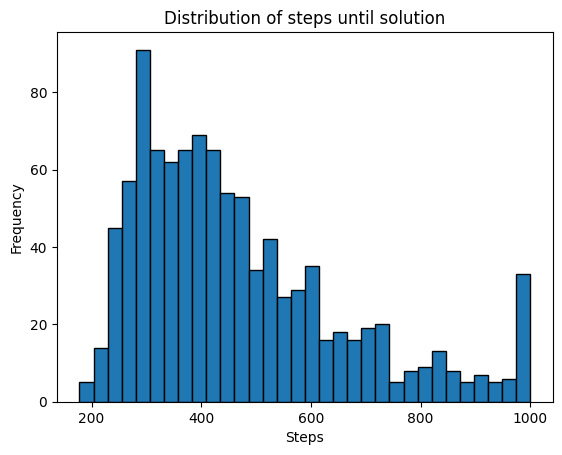

 ------------- 


In [40]:
import copy 
import matplotlib.pyplot as plt

test_environment = Environment(10, dirt_prob=0.3)
num_tests = 1000
results = {'initial_position': [], 'steps_until_solution': [], 'solution_found': []}


for i in range(num_tests):
    env = copy.deepcopy(test_environment)
    actions = [Move("up", env), Move("down", env), Move("left", env), Move("right", env), Suck()]
    initial_position = (random.randint(0, env.grid.shape[0]-1), random.randint(0, env.grid.shape[1]-1))
    initial_position = (0, 0)
    agent = Agent(State(position=initial_position), environment=env)

    results['initial_position'].append(initial_position)

    best_first_search = BestFirstSearch(agent, evaluate_function, actions)
    result_msg, agent_history = best_first_search.run(max_iterations=1000)

    results['steps_until_solution'].append(len(agent_history.actions))
    results['solution_found'].append(agent.environment.check_goal())


print('=========== Study of Best First Search Efficiency ============ ')
print(f'Solution found in {sum(results["solution_found"])} out of {num_tests} tests. {sum(results["solution_found"])/num_tests*100}%')
print("---" * 10)
print("Mean of steps until solution: ", sum(results['steps_until_solution'])/len(results['steps_until_solution']))
print("Median of steps until solution: ", sorted(results['steps_until_solution'])[len(results['steps_until_solution'])//2])
print("Standard deviation of steps until solution: ", np.std(results['steps_until_solution']))

print("---"*10)
print("Distribution of steps until solution")
print(" ------------- ")
plt.hist(results['steps_until_solution'], bins=round(num_tests**(1/2)), edgecolor='black')
plt.title('Distribution of steps until solution')
plt.xlabel('Steps')
plt.ylabel('Frequency')
plt.show()
print(" ------------- ")


In [31]:
for idx, state in np.ndenumerate(agent_history.environment.grid):
    print(state.position, state.dirt)

for action in agent_history.actions:
    print(action)

(0, 0) True
(0, 1) False
(0, 2) False
(1, 0) True
(1, 1) True
(1, 2) False
(2, 0) True
(2, 1) False
(2, 2) True
Move right
Move up
Move down
Move up
Move down
Move right
Move left
Move left
Move right
Move up
Move down
Move up
Move down
Move right
Move left
Move up
Move down
Move up
Move down
Move up
Move down
Move right
Move left
Move left
Move right
Move left
Move right
Move up
Move down
Move right
Move left
Move right
Move left
Move right
Move left
Move right
Move left
Move right
Move left
Move right
Move left
Move up
Move down
Move left
Move right
Move right
Move left
Move left
Move right
Move right
Move left
Move up
Move down
Move right
Move left
Move up
Move down
Move right
Move left
Move right
Move left
Move right
Move left
Move right
Move left
Move left
Move right
Move up
Move down
Move left
Move right
Move left
Move right
Move left
Move right
Move up
Move down
Move left
Move right
Move left
Move right
Move left
Move right
Move left
Move right
Move left
Move right
Move left
Mov

In [14]:
agent.state.position

(0, 0)